## Import modules

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import datetime
from scipy.sparse import coo_matrix, csr_matrix
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import  matplotlib.dates as mdates
from tqdm import tqdm

sys.path.insert(0, '/mnt/afml/ml_finance/mlfinlab')
import mlfinlab as ml
from mlfinlab.data_structures import imbalance_data_structures as imbar, run_data_structures as rbar, standard_data_structures as bar

sys.path.insert(0, '/mnt/afml/ml_finance/finance_ml')
from finance_ml.multiprocessing import mp_pandas_obj
from finance_ml import sampling

## Plot

In [2]:
def plot_bars(df, df_bar, desc='bar'):
    plt.figure(figsize = (18, 8))
    plt.title('Bars over the prices')
    plt.plot(df.index, df['PRICE'], label = 'Raw prices', color = 'blue')
    plt.plot(df_bar.index, df_bar['close'], ls = '', markersize = 5, marker = 'o', color = 'red', label = desc)
    plt.legend()
    plt.show()

In [3]:
def plot_mat(mat0, figsize, markersize): 
    # plot sparse matrix
    plt.figure(figsize=figsize) 
    plt.title("IndM")
    plt.spy(mat0, precision=0.001, marker='o', markersize=markersize)

    plt.show()

In [4]:
def plot_co_events(d0, df, t_barrier_events, num_co_events, avg_uniq): 
    df0 = df.loc[d0]
    t_barrier_events0 = t_barrier_events.loc[d0]
    num_co_events0 = num_co_events.loc[d0]
    avg_uniq0 = avg_uniq.loc[d0]
    
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(111)

    plt.title('Triple barriers over the prices')
    plt.plot(df0.index.values, df0.close.values, label='raw_prices', ls='--', color='black')

    # Draw barrier region 
    for i in t_barrier_events0.itertuples(): 
        try: 
            t0, t1, trgt = i.Index, i.t1, i.trgt
            t1 = min(t1, pd.Timestamp("{} 15:30".format(d0)))

            x0 = mdates.date2num(t0)
            x1 = mdates.date2num(t1)
            w = x1 - x0 

            y0 = df0.loc[t0].close * (1 - trgt)
            y1 = df0.loc[t0].close * (1 + trgt)
            h = y1 - y0

            rect = Rectangle((x0, y0), w, h, color='black', alpha=0.05)
            ax.add_patch(rect)

            df1 = df0.loc[[t0, t1]].dropna()

            plt.plot(df1.index.values, df1.close.values, label='triple barrier', ls='--', color='red')
            if df1.shape[0] >= 2:
                plt.scatter(df1.index.values[1], df1.close.values[1], marker='o', linewidths=5, color='red')
                
        except Exception as e:
            print(e)
    plt.show()
    
    # Draw num of co-events
    num_co_events0.plot(kind='bar', figsize=(30,10), label='DV')
    plt.show()
    
    # Draw average uniqueness
    avg_uniq0.plot(kind='bar', figsize=(30,10), label='AvgUniqueness')
    plt.show()

## Load data

In [5]:
def load_parq(fname):
    table = pq.read_table(fname)
    df = table.to_pandas()
    df = df.set_index('TIMESTAMP')
    ''' 중복된 index 제거, volume은 더해준다 '''
    df = df.sort_values(by='TIMESTAMP')  # 중복 데이터 무시
    df_v = df.groupby(df.index).sum()
    df = df.loc[~df.index.duplicated(keep='first')]
    df['V'] = df_v['V']
    df['DV'] = df_v['DV']
    return df

In [6]:
fname = 'dataset/TRADE_A233740_2018.parq'
df = load_parq(fname)
df['close'] = df['PRICE']

In [7]:
fname = 'dataset/TRADE_A233740_2018.csv'
if not os.path.exists(fname):
    df_csv = df.reset_index()[['TIMESTAMP', 'PRICE', 'V']]
    df_csv.columns = ['date_time', 'price', 'volume']
    df_csv['price'] = df_csv['price'].astype('float')
    df_csv.to_csv(fname, index=False)

fname = 'dataset/VBAR_A233740_2018.csv'

if os.path.exists(fname):
    vbar = pd.read_csv(fname, index_col='date_time')
    vbar.index = pd.to_datetime(vbar.index)
else:
    vbar = bar.get_volume_bars(fname, threshold=1e4)
    vbar.index = pd.to_datetime(vbar.index)
    vbar.to_csv(fname)

## Triple barrier

In [8]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=vbar['close'], lookback=50)

daily_vol_mean = daily_vol.rolling(10000).mean()  # about 5 days's mean
daily_vol_mean.dropna(inplace=True)
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(vbar['close'], daily_vol_mean=daily_vol_mean)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=vbar['close'], num_days=1)

Timestamp('2018-01-03 09:00:21.481000')
Timestamp('2018-01-04 09:00:03.287000')
Timestamp('2018-01-05 09:00:23.251000')
Timestamp('2018-01-08 09:00:02.607000')
Timestamp('2018-01-09 09:00:24.552000')
Timestamp('2018-01-10 09:00:18.700000')


In [9]:
print(vbar.shape)
print(cusum_events.shape)
print(vertical_barriers.shape)

(331841, 5)
(18087,)
(18021,)


## Build Label

In [10]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=vbar['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers)

/mnt/afml/ml_finance/mlfinlab/mlfinlab/labeling/labeling.py:117: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-05-31 17:53:44.533655 100.0% apply_pt_sl_on_t1 done after 0.12 minutes. Remaining 0.0 minutes.


In [11]:
print(triple_barrier_events.shape)

(4275, 2)


In [12]:
vertical_barriers.loc[vertical_barriers.index>datetime.datetime(2018,5,24,9,0)].head()

2018-05-24 09:00:44.746   2018-05-25 09:00:56.925
2018-05-24 09:01:21.146   2018-05-25 09:01:37.289
2018-05-24 09:06:45.908   2018-05-25 09:06:55.548
2018-05-24 09:18:52.366   2018-05-25 09:19:03.236
2018-05-24 09:24:40.418   2018-05-25 09:24:50.244
Name: date_time, dtype: datetime64[ns]

In [13]:
triple_barrier_events.loc[triple_barrier_events.index>datetime.datetime(2018,5,23,9,0)].head()

,t1,trgt
2018-05-24 10:24:00.710,2018-05-24 10:35:02.874,0.005097
2018-05-24 12:11:01.404,2018-05-24 14:35:43.655,0.005745
2018-05-25 09:03:29.976,2018-05-25 09:33:35.344,0.008633
2018-05-25 09:04:41.116,2018-05-25 09:09:41.239,0.008235
2018-05-25 09:06:35.024,2018-05-25 09:23:20.887,0.007572


## Concurrency and Uniqueness

In [14]:
def get_num_co_events(close_idx, t1, molecule):
    # Find events that span the period defined by molecule
    t1 = t1.fillna(close_idx[-1])
    t1 = t1[t1 >= molecule[0]]
    t1 = t1.loc[:t1[molecule].max()]
    # Count the events
    iloc = close_idx.searchsorted(np.array([t1.index[0], t1.max()]))
    count = pd.Series(0, index=close_idx[iloc[0]: iloc[1] + 1])
    for t_in, t_out in t1.iteritems():
        count.loc[t_in: t_out] += 1
    return count.loc[molecule[0]: t1[molecule].max()]

In [15]:
num_threads = 3
num_co_events = mp_pandas_obj(get_num_co_events,
                              ('molecule', triple_barrier_events.index),
                              num_threads,
                              close_idx=vbar.index,
                              t1=triple_barrier_events['t1'])

# num_co_events = num_co_events.loc[~num_co_events.index.duplicated(keep='last')]
# num_co_events = num_co_events.reindex(close.index).fillna(0)

2019-05-31 17:53:47.416167 100.0% get_num_co_events done after 0.04 minutes. Remaining 0.0 minutes.


## Get avg uniqueness

In [16]:
def get_sample_tw(t1, num_co_events, molecule):
    wght = pd.Series(index=molecule)
    for t_in, t_out in t1.loc[wght.index].iteritems():
        wght.loc[t_in] = (1. / num_co_events.loc[t_in: t_out]).mean()
    return wght

In [17]:
num_co_events = num_co_events.loc[~num_co_events.index.duplicated(keep='last')]
num_co_events = num_co_events.reindex(vbar.index).fillna(0)
tw = mp_pandas_obj(get_sample_tw,
                   ('molecule', triple_barrier_events.index),
                   num_threads,
                   t1=triple_barrier_events['t1'],
                   num_co_events=num_co_events)

2019-05-31 17:53:49.815407 100.0% get_sample_tw done after 0.03 minutes. Remaining 0.0 minutes.


/mnt/afml/venv/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


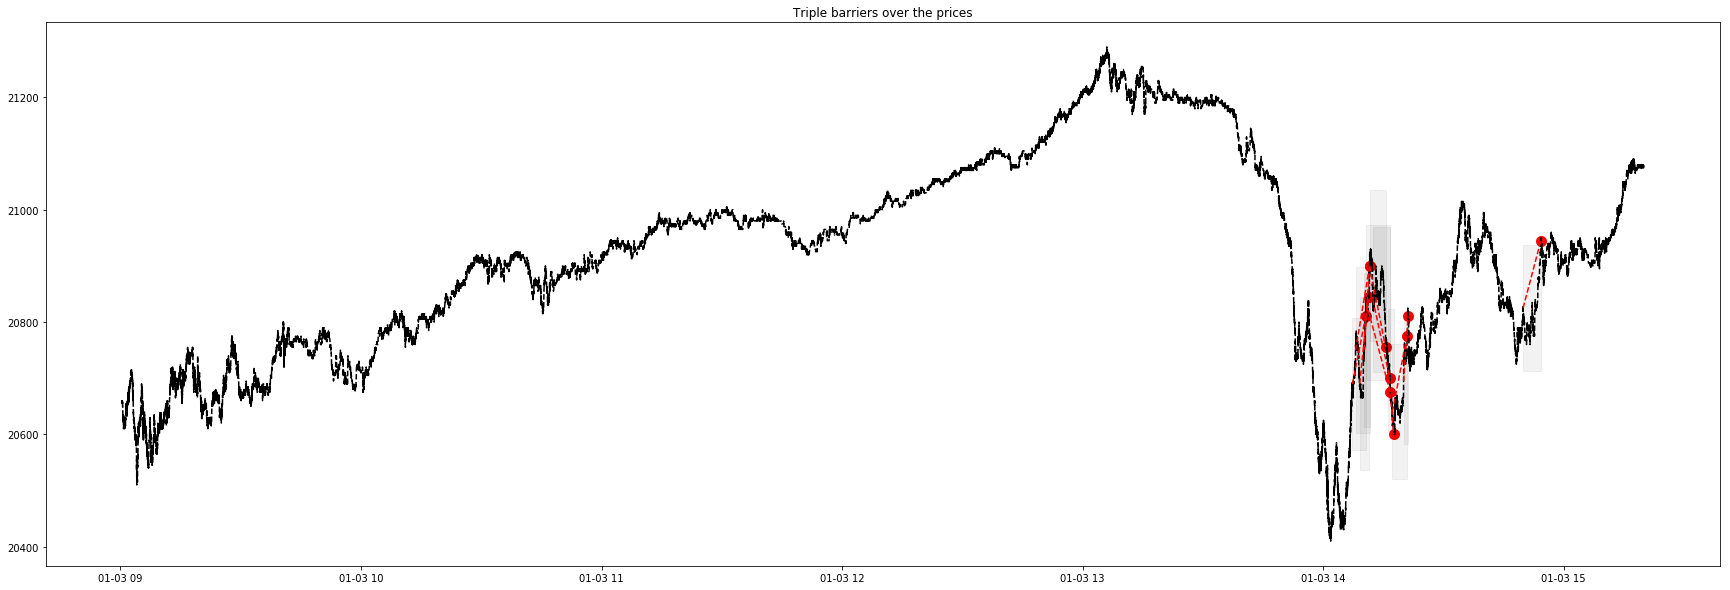

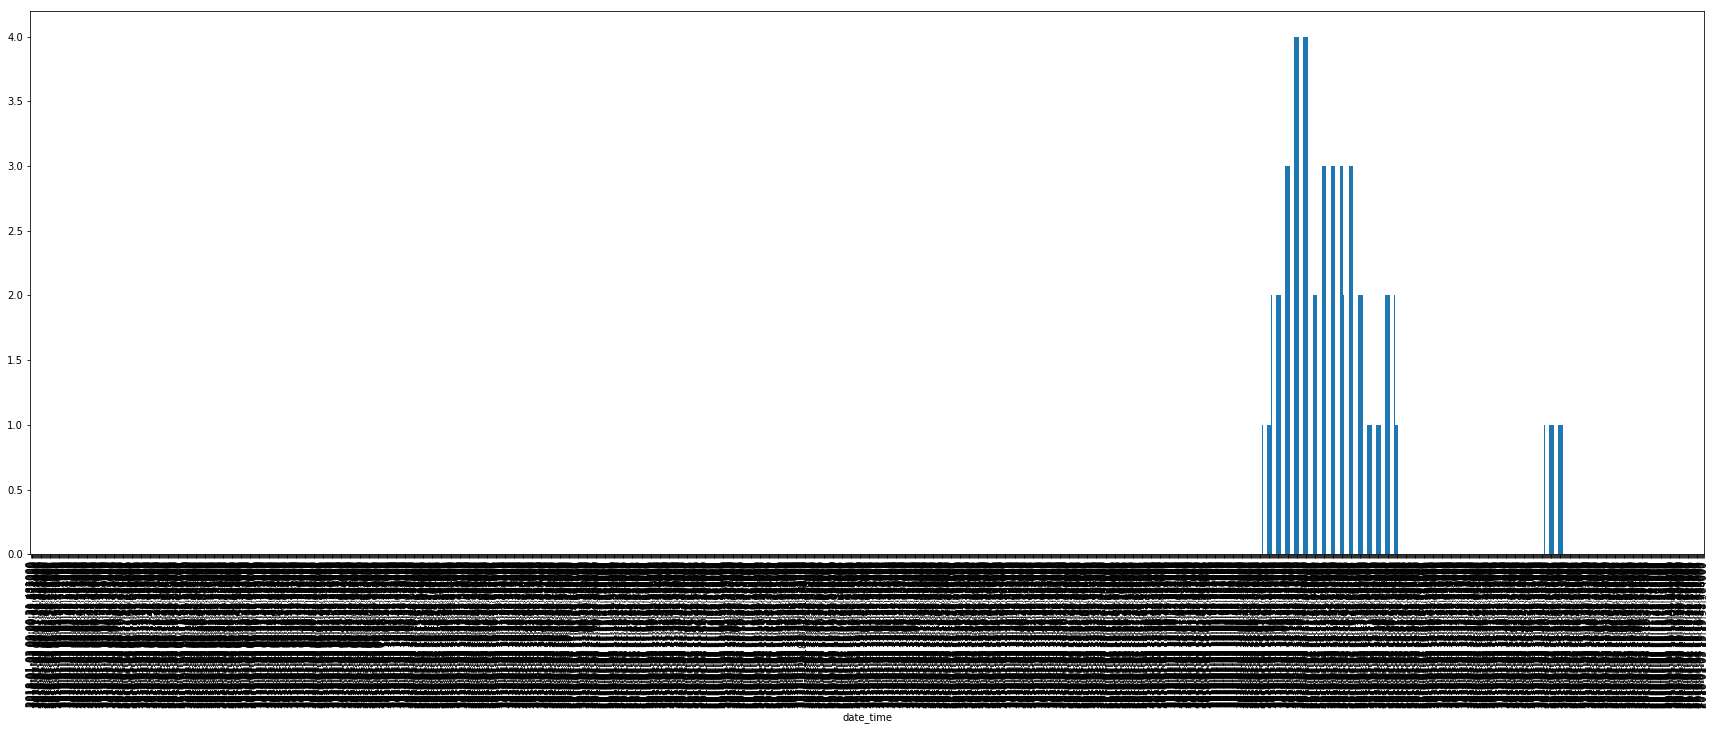

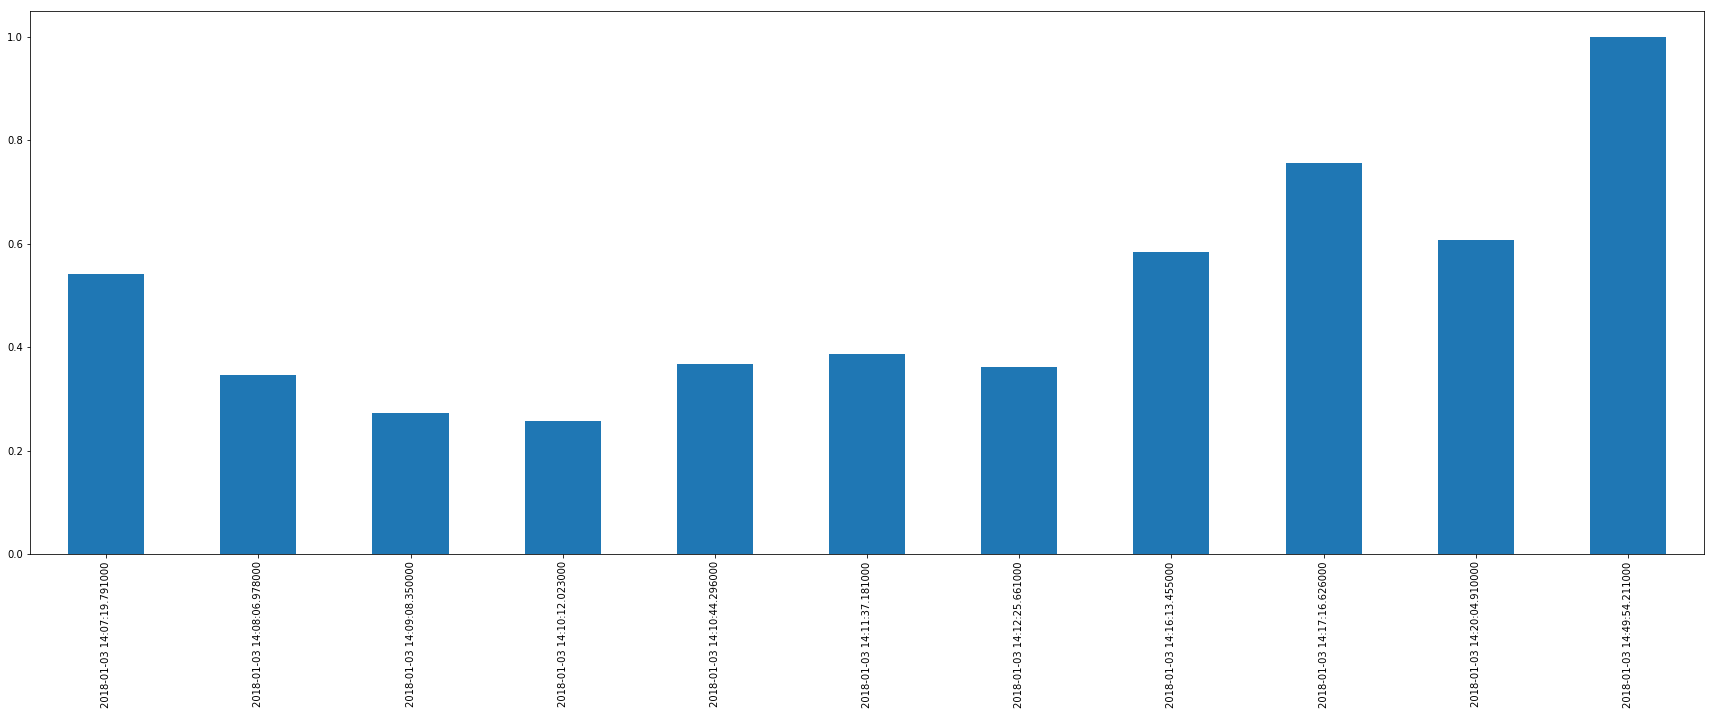

In [18]:
plot_co_events('2018-01-03', df, triple_barrier_events, num_co_events, tw)

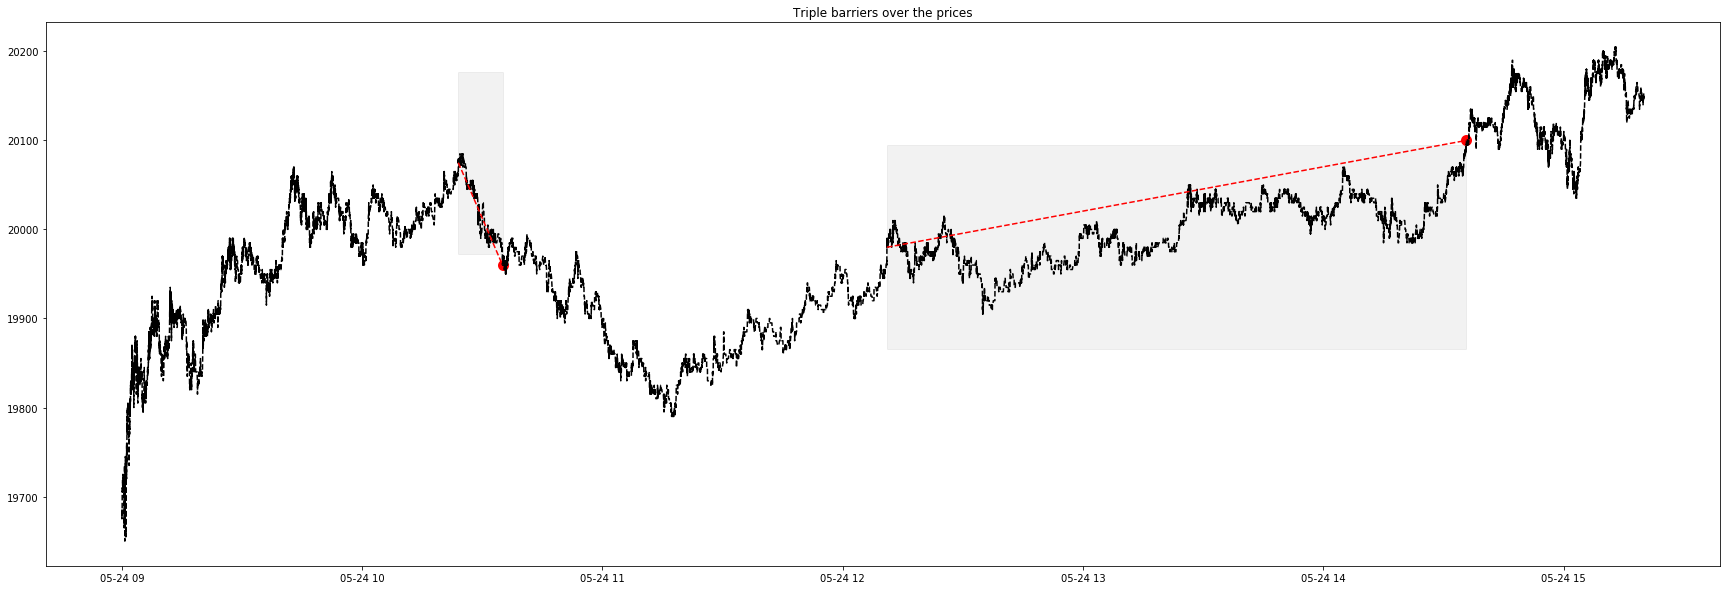

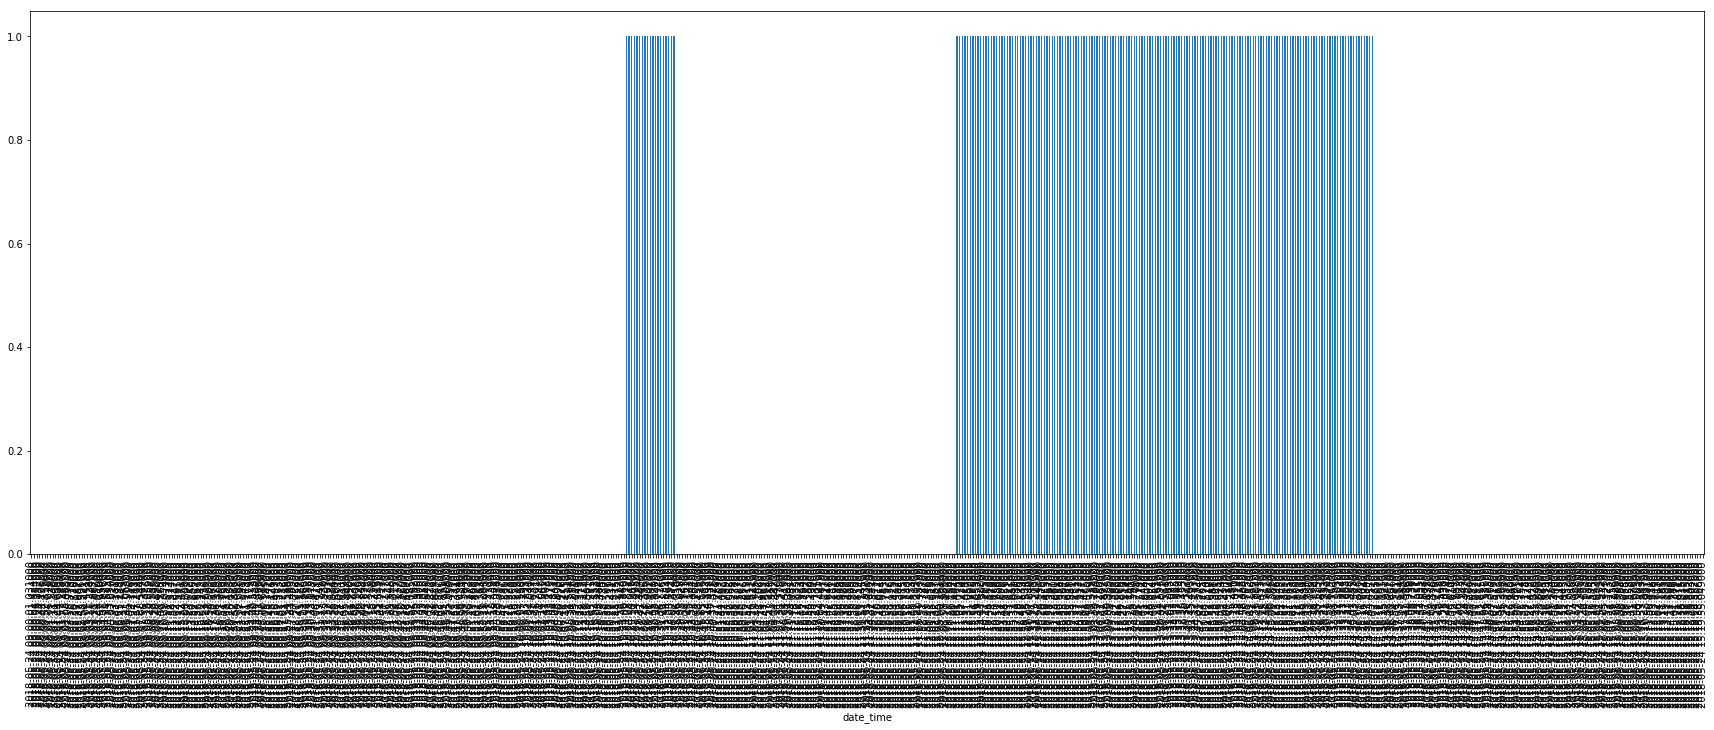

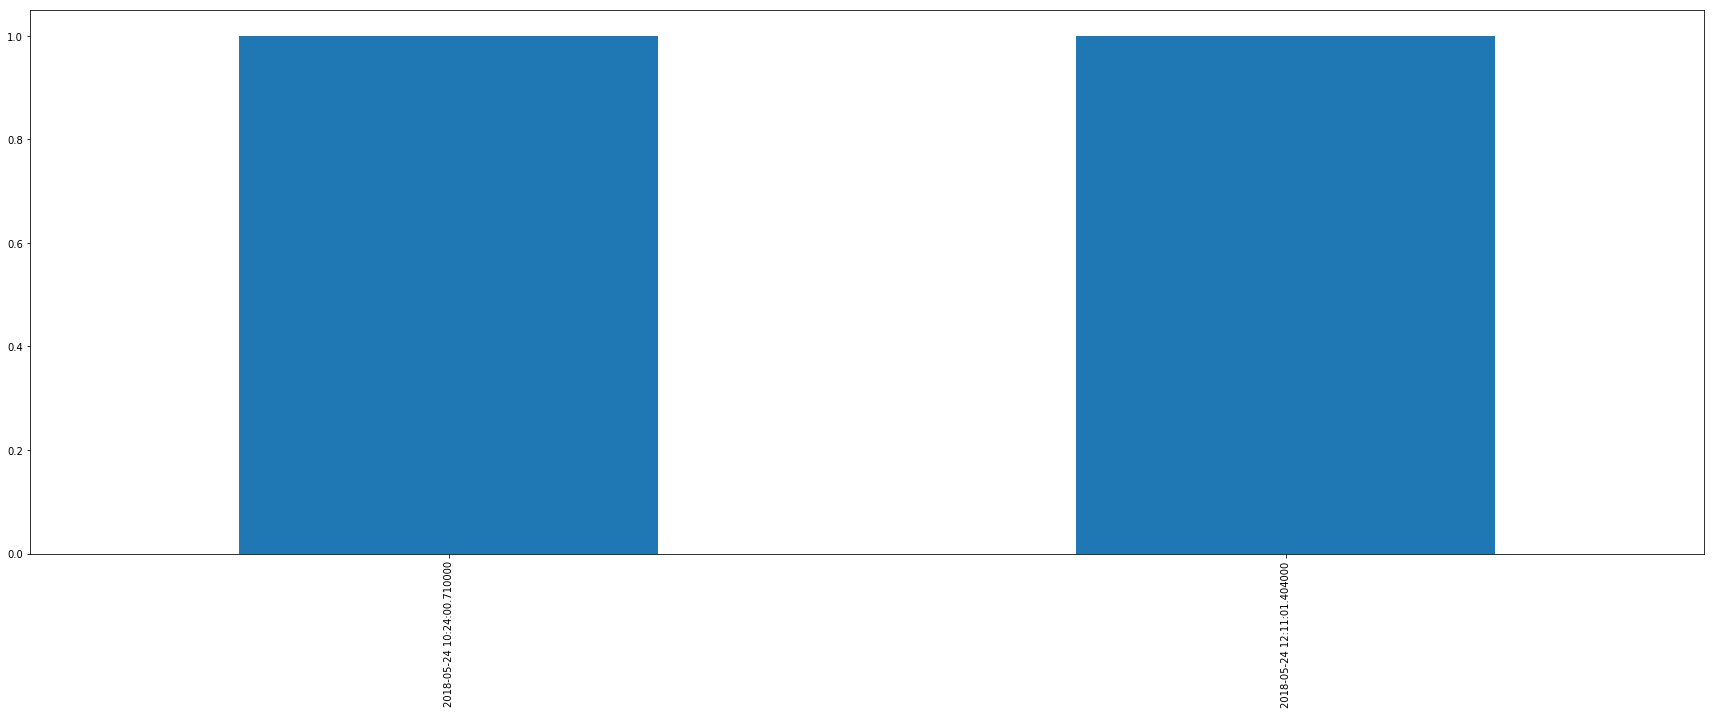

In [19]:
plot_co_events('2018-05-24', df, triple_barrier_events, num_co_events, tw)

## 4.5 Sequential Bootstrap

In [20]:
def get_baridx_t1(bar, t_events): 
    # ind_mat을 만들기 위해 바의 (start, end)의 loc 값을 array로 만들어준다
    list_beg = []
    list_end = []

    for i in t_events.itertuples():
        try: 
            t0_ = bar.index.get_loc(i.Index)
            t1_ = bar.index.get_loc(i.t1)

            list_beg.append(t0_)
            list_end.append(t1_)

        except Exception as e: 
            try:
                idx_ = bar.loc[:i.Index].index[-1]
                t1_ = bar.loc[:i.t1].index[-1]
                
                t0_ = bar.index.get_loc(idx_)
                t1_ = bar.index.get_loc(t1_)
                list_beg.append(t0_)
                list_end.append(t1_)
            except Exception as e:
                print(e)
                print(i)


    beg_arr = np.array(list_beg)
    end_arr = np.array(list_end)


    t1 = pd.Series(end_arr, index=beg_arr)
    bar_idx = np.arange(t1.max() + 1)
    return bar_idx, t1

In [21]:
# seq bootrap with all data runs forever..
# bar_idx, t1 = sampling.get_baridx_t1(vbar, triple_barrier_events)
# seq_phi = sampling.seq_bootstrap(ind_m, verbose=False)

In [22]:
beg_date = vbar.index[0].date()
end_date = vbar.index[-1].date()
print(beg_date, end_date)

2018-01-02 2018-12-28


In [ ]:
cur_bar_date = beg_date
step_day = 14
seq_phi_t1_idx = []
while cur_bar_date < end_date:
    cur_t1_date = cur_bar_date + datetime.timedelta(days=1)
    end_t1_date = cur_t1_date + datetime.timedelta(days=step_day)
    
    print("process {} - {}, total seq {}".format(cur_t1_date, end_t1_date, len(seq_phi_t1_idx)))
    sub_vbar = vbar.loc[cur_bar_date:end_t1_date]
    sub_t1 = triple_barrier_events.loc[cur_bar_date:end_t1_date]
    if len(sub_t1) == 0:
        print("len sub_t1 is zero")
        cur_bar_date += datetime.timedelta(days=step_day)
        continue
    bar_idx, t1 = get_baridx_t1(sub_vbar, sub_t1)
    
    
    ind_m = sampling.get_ind_matrix(bar_idx, t1)
    seq_phi = sampling.seq_bootstrap(ind_m, verbose=False)
    
    seq_phi_t1_idx += sub_t1.iloc[seq_phi].sort_index().loc[cur_t1_date:end_t1_date].index
    cur_bar_date += datetime.timedelta(days=step_day)
print(len(seq_phi_t1_idx))

In [28]:
print(vbar.loc[seq_phi_t1_idx].shape)
print(triple_barrier_events.loc[seq_phi_t1_idx].shape)

(4273, 5)
(4273, 2)


## MonteCarlo

In [52]:
def getRndT1(numObs, numBars, maxH):
    # random t1 Series 
    t1=pd.Series()
    for i in range(numObs):
        ix = np.random.randint(0, numBars)
        val = ix + np.random.randint(1, maxH)
        t1.loc[ix] = val
    return t1.sort_index()

In [27]:
def simpleBootstrap(indM, sLength=None):
    # Generate a sample via bootstrap
    if sLength is None:
        sLength = indM.shape[1]
        
    phi=[] 
    avgU = get_avg_uniq(indM)
    prob = avgU/avgU.sum()  # draw prob
    while len(phi) < sLength:
        phi += [np.random.choice(indM.columns, p=prob)]
    return phi

In [28]:
def auxMC(numObs, numBars, maxH):
    # Parallelized auxiliary function
    t1 = getRndT1(numObs, numBars, maxH)
    barIx = range(t1.max()+1)
    indM = get_ind_matrix(barIx, t1)
    phi = np.random.choice(indM.columns, size=indM.shape[1])
    stdU = get_avg_uniq(indM[phi]).mean()
    phi = simpleBootstrap(indM)
    simU = get_avg_uniq(indM[phi]).mean()
    phi = seqBootstrap(indM)
    seqU = get_avg_uniq(indM[phi]).mean()
    return {'stdU':stdU, 'simU':simU, 'seqU':seqU}

In [ ]:
for _ in range(10):
    numObs = np.random.randint(50,200)
    numBars = np.random.randint(200,1000)
    maxH = np.random.randint(5,20)
    res = auxMC(numObs, numBars, maxH)
    print(res)

## 4.6 Return Attribution (Sample Weight)

In [30]:
from finance_ml.sampling import time_weight
wgt = time_weight.get_sample_weight(np.log(vbar['close']).diff(), triple_barrier_events['t1'], num_co_events)

In [31]:
print(wgt.shape)
print(wgt.head())

(4275,)
2018-01-03 14:07:19.791    0.943672
2018-01-03 14:08:06.978    0.653036
2018-01-03 14:09:08.350    0.586201
2018-01-03 14:10:12.023    0.665584
2018-01-03 14:10:44.296    0.960689
dtype: float64


### - sample weight might handle as sklearn fit parameter

## Time Decay

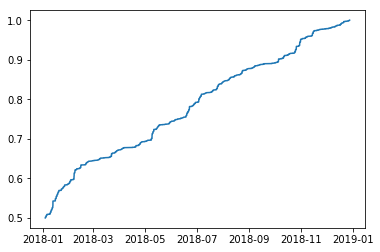

In [42]:
from finance_ml.sampling import weight
td = weight.get_time_decay(tw, last_w=0.5)
plt.plot(td)

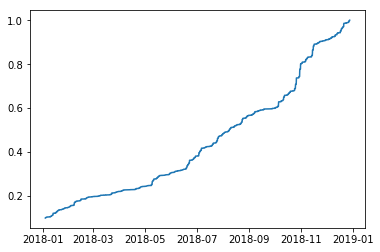

In [34]:
td = weight.get_time_decay(tw, last_w=0.1, is_exp=True)
plt.plot(td)

In [40]:
wgt.head()

2018-01-03 14:07:19.791    0.943672
2018-01-03 14:08:06.978    0.653036
2018-01-03 14:09:08.350    0.586201
2018-01-03 14:10:12.023    0.665584
2018-01-03 14:10:44.296    0.960689
dtype: float64

In [41]:
td.head()

2018-01-03 14:07:19.791    0.000341
2018-01-03 14:08:06.978    0.000558
2018-01-03 14:09:08.350    0.000730
2018-01-03 14:10:12.023    0.000892
2018-01-03 14:10:44.296    0.001123
dtype: float64

In [43]:
(wgt * td).head()

2018-01-03 14:07:19.791    0.471997
2018-01-03 14:08:06.978    0.326700
2018-01-03 14:09:08.350    0.293314
2018-01-03 14:10:12.023    0.333089
2018-01-03 14:10:44.296    0.480884
dtype: float64